In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-leastsq-fitting)=
# Fitting functions to data

```{index} interpolation; by polynomials
```

In {numref}`section-linsys-polyinterp` we saw how a polynomial can be used to interpolate data—that is, derive a continuous function that evaluates to give a set of prescribed values. But interpolation may not be appropriate in many applications.

(demo-fitting-tempinterp)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here are 5-year averages of the worldwide temperature anomaly as compared to the 1951–1980 average (source: NASA).

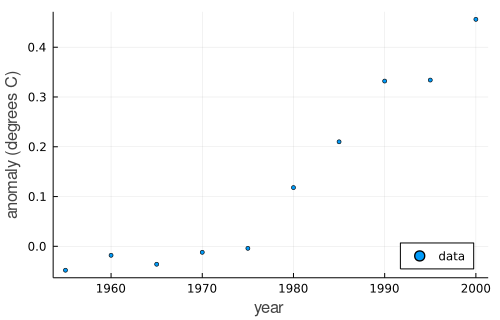

In [2]:
year = 1955:5:2000
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
       0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]
    
scatter(year,temp,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)

A polynomial interpolant can be used to fit the data. Here we build one using a Vandermonde matrix. First, though, we express time as decades since 1950, as it improves the condition number of the matrix.

In [3]:
t = @. (year-1950)/10
n = length(t)
V = [ t[i]^j for i in 1:n, j in 0:n-1 ]
c = V\temp

10-element Vector{Float64}:
  -14.114000002897516
   76.36173811075241
 -165.45597225538512
  191.9605667047853
 -133.27347224857206
   58.0155777892561
  -15.962888892063518
    2.694806349746933
   -0.2546666667183191
    0.010311111113228591

```{index} Julia; plotting functions
```


::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
The coefficients in vector `c` are used to create a polynomial. Then we create a function that evaluates the polynomial after changing the time variable as we did for the Vandermonde matrix.
```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
If you `plot` a function, then the points are chosen automatically to make a smooth curve.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

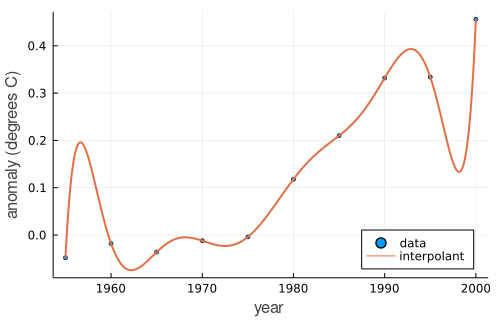

In [4]:
p = Polynomial(c)
f = yr -> p((yr-1950)/10)
plot!(f,1955,2000,label="interpolant")

As you can see, the interpolant does represent the data, in a sense. However it's a crazy-looking curve for the application. Trying too hard to reproduce all the data exactly is known as _overfitting_.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


```{index} data fitting
```

In many cases we can get better results by relaxing the interpolation requirement. In the polynomial case this allows us to lower the degree of the polynomial, which limits the number of local max and min points. Let $(t_i,y_i)$ for $i=1,\ldots,m$ be the given points. We will represent the data by the polynomial

```{math}
:label: vanderls
y \approx f(t) = c_1 + c_2t + \cdots + c_{n-1} t^{n-2} + c_n t^{n-1},
```

with $n<m$. Just as in {eq}`vandersystem`, we can express a vector of $f$-values by a matrix-vector multiplication. In other words, we seek an approximation

```{math}
:label: vandersystemrect
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_m \end{bmatrix} \approx
\begin{bmatrix}
f(t_1)                               \\
f(t_2)                               \\
f(t_3)                               \\
\vdots                               \\
f(t_m)
\end{bmatrix} =
\begin{bmatrix}
1      & t_1    & \cdots & t_1^{n-1} \\
1      & t_2    & \cdots & t_2^{n-1} \\
1      & t_3    & \cdots & t_3^{n-1} \\
\vdots & \vdots &        & \vdots    \\
1      & t_m    & \cdots & t_m^{n-1} \\
\end{bmatrix}
\begin{bmatrix}
c_1                                  \\
c_2                                  \\
\vdots                               \\
c_n
\end{bmatrix}
= \mathbf{V} \mathbf{c}.
```

```{index} Vandermonde matrix
```

Note that $\mathbf{V}$ has the same structure as the Vandermonde matrix in {eq}`vandersystem` but is $m\times n$, thus taller than it is wide. It's impossible in general to satisfy $m$ conditions with $n<m$ variables, and we say the system is **overdetermined**. Rather than solving the system exactly, we have to find a best approximation. Below we specify precisely what is meant by this, but first we note that Julia uses the same backslash notation to solve the problem in both the square and overdetermined cases.

(demo-fitting-tempfit)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```


Here are the 5-year temperature averages again.

In [5]:
year = 1955:5:2000
t = @. (year-1950)/10
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
          0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]

10-element Vector{Float64}:
 -0.048
 -0.018
 -0.036
 -0.012
 -0.004
  0.118
  0.21
  0.332
  0.334
  0.456

```{index} Julia; \\
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
The standard best-fit line results from using a linear polynomial that meets the least-squares criterion.
```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
Backslash solves overdetermined linear systems in a least-squares sense.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [6]:
V = [ t.^0 t ]    # Vandermonde-ish matrix
@show size(V)
c = V\temp
p = Polynomial(c)

size(V) = (10, 2)


Polynomial(-0.18773333333333328 + 0.11670303030303028*x)

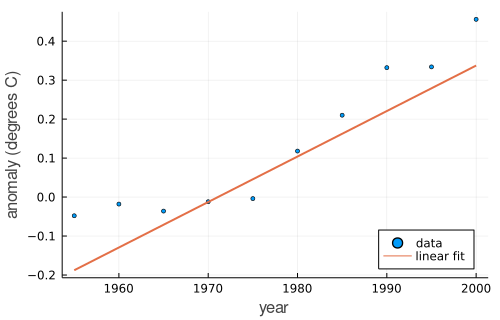

In [7]:
f = yr -> p((yr-1955)/10)
scatter(year,temp,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)
plot!(f,1955,2000,label="linear fit")

If we use a global cubic polynomial, the points are fit more closely.

In [8]:
V = [ t[i]^j for i in 1:length(t), j in 0:3 ]   
@show size(V)

size(V) = (10, 4)


(10, 4)

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Now we solve the new least-squares problem to redefine the fitting polynomial.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The definition of `f` above is in terms of `p`. When `p` is changed, then `f` calls the new version.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

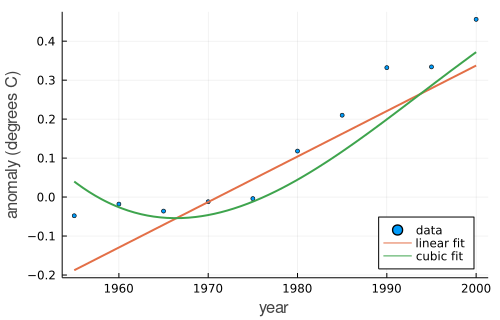

In [9]:
p = Polynomial( V\temp )

plot!(f,1955,2000,label="cubic fit")

If we were to continue increasing the degree of the polynomial, the residual at the data points would get smaller, but overfitting would increase.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## The least-squares formulation

In the most general terms, our fitting functions take the form

```{math}
:label: fitbasis
f(t) = c_1 f_1(t) + \cdots + c_n f_n(t)
```

where $f_1,\ldots,f_n$ are all known functions with no undetermined parameters. This leaves only $c_1,\ldots,c_n$ to be determined. The essential feature of a linear least-squares problem is that the fit depends only *linearly* on the unknown parameters. For instance, a function of the form $f(t)=c_1 + c_2 e^{c_3 t}$ is not of this type.

At each observation $(t_i,y_i)$, we define a residual, $y_i - f(t_i)$. A sensible formulation of the fitting criterion is to minimize

```{math}
  R(c_1,\ldots,c_n) = \sum_{i=1}^m\, [ y_i - f(t_i) ]^2,
```

over all possible choices of parameters $c_1,\ldots,c_n$. We can apply linear algebra to write the problem in the form $R=\mathbf{r}^T \mathbf{r}$, where

```{math}
\mathbf{r} =
\begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\y_{m-1} \\ y_m
\end{bmatrix} -
\begin{bmatrix}
f_1(t_1) & f_2(t_1) & \cdots & f_n(t_1) \\[1mm]
f_1(t_2) & f_2(t_2) & \cdots & f_n(t_2) \\[1mm]
& \vdots \\
f_1(t_{m-1}) & f_2(t_{m-1}) & \cdots & f_n(t_{m-1}) \\[1mm]
f_1(t_m) & f_2(t_m) & \cdots & f_n(t_m) \\[1mm]
\end{bmatrix}
\begin{bmatrix}
c_1 \\ c_2 \\ \vdots \\ c_n
\end{bmatrix}.
```

```{index} linear least-squares problem
```

Recalling that $\mathbf{r}^T\mathbf{r}=\| \mathbf{r} \|_2^2$, and renaming the variables to standardize the statement, we arrive at the general **linear least-squares problem**.

```{index} ! argmin
```

(definition-fitting-linearls)=
````{proof:definition} Linear least-squares problem
Given $\mathbf{A}\in\mathbb{R}^{m \times n}$ and $\mathbf{b}\in\mathbb{R}^m$, with $m>n$, find

```{math}
:label: linls
\argmin_\limits{\mathbf{x}\in \mathbb{R}^n}\,  \bigl\| \mathbf{b}-\mathbf{A} \mathbf{x} \bigr\|_2^2.
```
````

The notation **argmin** above means to find an $\mathbf{x}$ that produces the minimum value.

```{index} norm; vector
```

While we could choose to minimize in any vector norm, the 2-norm is the most common and convenient choice. *For the rest of this chapter we exclusively use the 2-norm.* In the edge case $m=n$ for a nonsingular $\mathbf{A}$, the definitions of the linear least-squares and linear systems problems coincide: the solution of  $\mathbf{A}\mathbf{x}=\mathbf{b}$  implies $\mathbf{r}=\boldsymbol{0}$, which is a global minimum of $\| \mathbf{r} \|_2^2 \ge 0$.

## Change of variables

```{index} data fitting; by straight line
```

The most familiar and common case of a polynomial least-squares fit is the straight line, $f(t) = c_1 + c_2 t$. Certain other fit functions can be transformed into this situation. For example, suppose we want to fit data using $g(t)= a_1 e^{a_2 t}$. Then

```{math}
:label: exptransfit
\log y \approx \log g(t) = (\log a_1) + a_2 t = c_1 + c_2 t.
```

```{index} data fitting; power law
```

While the fit of the $y_i$ to $g(t)$ is nonlinearly dependent on fitting parameters, the fit of $\log y$ to a straight line is a linear problem. Similarly, the power-law relationship $y\approx f(t)=a_1 t^{a_2}$ is equivalent to

```{math}
:label: powtransfit
\log y \approx (\log a_1) + a_2 (\log t).
```

(demo-fitting-pirate)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```


Finding numerical approximations to $\pi$ has fascinated people for millennia. One famous formula is

$$ 
\displaystyle \frac{\pi^2}{6} = 1 + \frac{1}{2^2} + \frac{1}{3^2} + \cdots. 
$$


Say $s_k$ is the sum of the first $k$ terms of the series above, and $p_k = \sqrt{6s_k}$. Here is a fancy way to compute these sequences in a compact code.

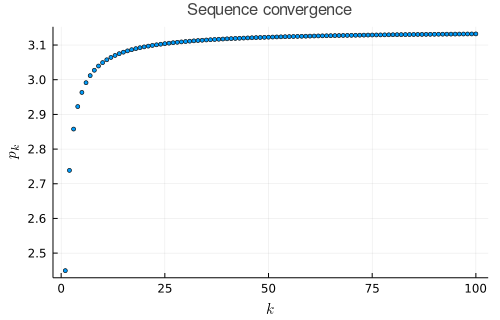

In [10]:
a = [1/k^2 for k=1:100] 
s = cumsum(a)        # cumulative summation
p = @. sqrt(6*s)

scatter(1:100,p,title="Sequence convergence",
    xlabel=L"k",ylabel=L"p_k")

This graph suggests that maybe $p_k\to \pi$, but it's far from clear how close the sequence gets. It's more informative to plot the sequence of errors, $\epsilon_k= |\pi-p_k|$. By plotting the error sequence on a log-log scale, we can see a nearly linear relationship.

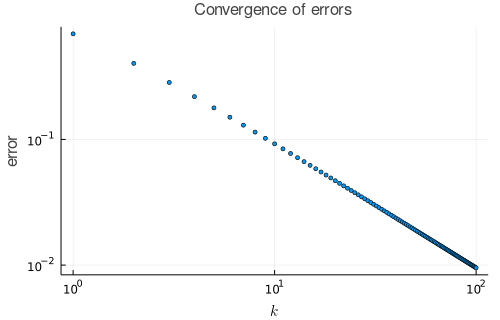

In [11]:
ϵ = @. abs(π-p)    # error sequence
scatter(1:100,ϵ,title="Convergence of errors",
    xaxis=(:log10,L"k"),yaxis=(:log10,"error"))

The straight line on the log-log scale suggests a power-law relationship where $\epsilon_k\approx a k^b$, or $\log \epsilon_k \approx b (\log k) + \log a$.

In [12]:
k = 1:100
V = [ k.^0 log.(k) ]     # fitting matrix
c = V \ log.(ϵ)          # coefficients of linear fit

2-element Vector{Float64}:
 -0.182375249728302
 -0.9674103233127926

In terms of the parameters $a$ and $b$ used above, we have

In [13]:
a,b = exp(c[1]),c[2];
@show b;

b = -0.9674103233127926


It's tempting to conjecture that the slope $b\to -1$ asymptotically. Here is how the numerical fit compares to the original convergence curve.

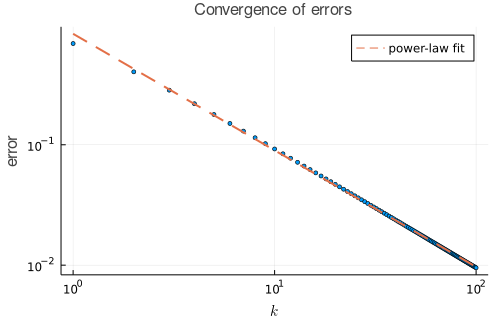

In [14]:
plot!(k,a*k.^b,l=:dash,label="power-law fit")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


Thus the variable $z=\log y$ can be fit linearly in terms of the variable $s=\log t$. In practice these two cases—exponential fit and power law—are easily detected by using log-linear or log-log plots, respectively.

## Exercises

1. ✍ Suppose $f$ is a twice-differentiable, nonnegative real function. Show that if there is an $x^*$ such that $f'(x^*)=0$ and $f''(x^*)>0$, then $x^*$ is a local minimizer of the function $[f(x)]^2$.

    (problem-fitting-census)=
2. ⌨  Here are counts of the U.S. population in millions from the census performed every ten years, beginning with 1790 and ending with 2010.

    ``` julia
    3.929, 5.308, 7.240, 9.638, 12.87, 17.07, 23.19, 31.44, 39.82, 50.19, 62.95, 76.21,
    92.22, 106.0, 122.8, 132.2, 150.7, 179.3, 203.3, 226.5, 248.7, 281.4, 308.7
    ```

    **(a)** Find a best-fitting cubic polynomial for the data. Plot the data as points superimposed on a (smooth) graph of the cubic over the full range of time. Label the axes. What does the fit predict for the population in the years 2000, 2010, and 2020?

    **(b)** Look up the actual U.S. population in 2000, 2010, and 2020 and compare to the predictions of part (a).

3. ⌨  The following are weekly box office earnings (in dollars) in the U.S. for the 2012 film *The Hunger Games*. (Source: boxofficemojo.com.)

    ```julia
    189_932_838, 79_406_327, 46_230_374, 26_830_921, 18_804_290,
    13_822_248, 7_474_688, 6_129_424, 4_377_675, 3_764_963, 2_426_574,
    1_713_298, 1_426_102, 1_031_985, 694_947, 518_242, 460_578, 317_909
    ```

    (Note that Julia lets you use `_` where you would normally put a comma in a long number.) Fit these values to a function of the form $y(t)\approx a e^{b t}$. Plot the data together with the fit using standard linear scales on the axes, and then plot them again using a log scale on the vertical axis.

4. ⌨  In this problem you are trying to find an approximation to the periodic function $g(t)=e^{\sin(t-1)}$ over one period, $0 < t \le 2\pi$. As data, define

    $$
    t_i = \frac{2\pi i}{60}, \; y_i = g(t_i), \quad i=1,\ldots,60.
    $$
   
    **(a)** Find the coefficients of the least-squares fit
  
    ```{math}
      y(t) \approx c_1 + c_2t + \cdots + c_7 t^6.
    ```

    Superimpose a plot of the data values as points with a curve showing the fit.

     **(b)** Find the coefficients of the least-squares fit

    ```{math}
    y \approx d_1 + d_2\cos(t) + d_3\sin(t) + d_4\cos(2t) + d_5\sin(2t).
    ```

    Unlike part (a), this fitting function is itself periodic. Superimpose a plot of the data values as points with a curve showing the fit. 

5. ⌨ Define the following data in Julia.

    ``` julia
    t = 0:.5:10
    y = tanh.(t)
    ```

     **(a)** Fit the data to a cubic polynomial. Plot the data together with the polynomial fit over the interval $0 \le t \le 10$.

      **(b)** Fit the data to the function $c_1 + c_2z + c_3z^2 + c_4z^3$, where $z=t^2/(1+t^2)$. Plot the data together with the fit. What feature of $z$ makes this fit much better than the original cubic?
  

6. ⌨  One series for finding $\pi$ is

    $$\frac{\pi}{2} = 1 + \frac{1}{3} + \frac{1\cdot 2}{3\cdot5} + \frac{1\cdot 2\cdot 3}{3\cdot 5\cdot 7} + \cdots.$$

    Define $s_k$ to be the sum of the first $k$ terms on the right-hand side, and let $e_k=|s_k-\pi/2|$. 
    
    **(a)** Calculate $e_k$ for $k=1,\ldots,20$, and plot the sequence on a log-linear scale.

    **(b)** Determine $a$ and $b$ in a least-squares fit $e_k \approx a \cdot b^k$, and superimpose the fit on the plot from part (a).
    
7.  ⌨  Kepler found that the orbital period $\tau$ of a planet depends on its mean distance $R$ from the sun according to $\tau=c R^{\alpha}$ for a simple rational number $\alpha$. Perform a linear least-squares fit from the following table in order to determine the most likely simple rational value of $\alpha$.

    | Planet  | Distance from sun in Mkm |  Orbital period in days              |
    |---------|:--------------------------------------------:|:-----------:|
    | Mercury | 57.59                                      | 87.99  |
    | Venus   | 108.11                                     | 224.7  |
    | Earth   | 149.57                                     | 365.26 |
    | Mars    | 227.84                                     | 686.98 |
    | Jupiter | 778.14                                     | 4332.4 |
    | Saturn  | 1427                                        | 10759   |
    | Uranus  | 2870.3                                     | 30684   |
    | Neptune | 4499.9                                     | 60188   |

8.  ✍ Show that finding a fit of the form

    ```{math}
    y(t) \approx \frac{a}{t+b}
    ```

    can be transformed into a linear fitting problem (with different undetermined coefficients) by rewriting the equation.

9.  ✍ Show how to find the constants $a$ and $b$ in a data fitting problem of the form $y(t)\approx t/(at+b)$ for $t>1$ by transforming it into a linear least-squares fitting problem.